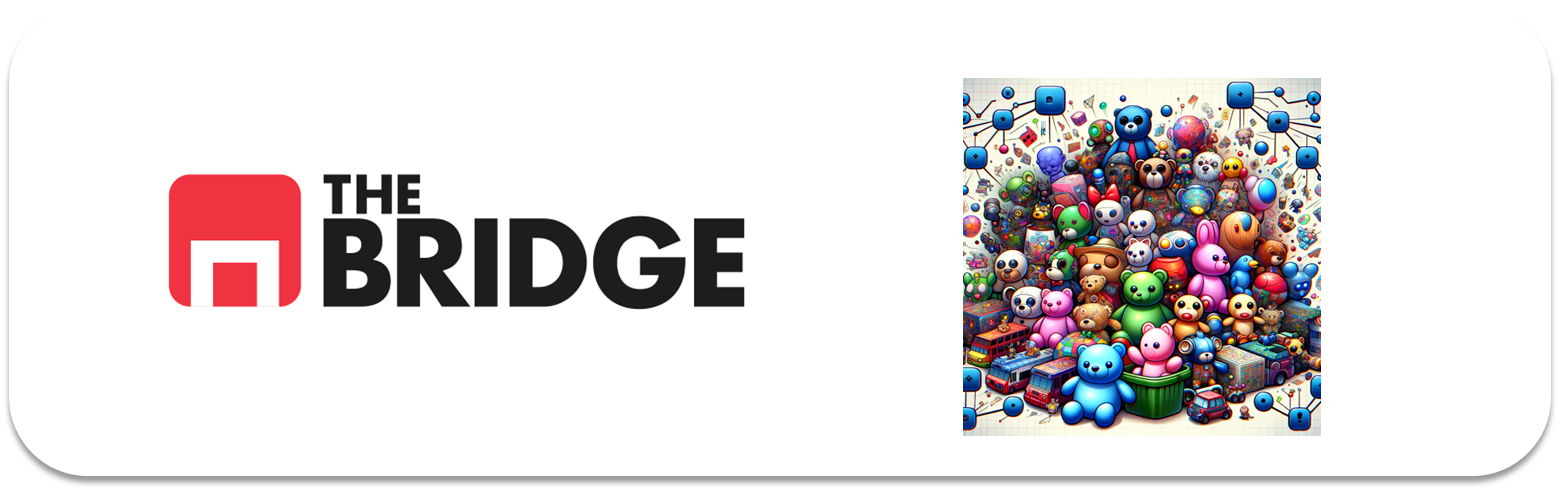

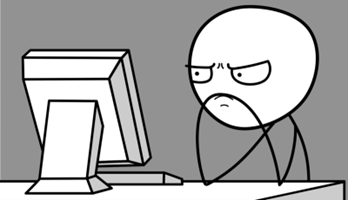

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La pr√°ctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jer√°rquico y no jer√°rquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendr√°s que descar los directorios de im√°genes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesi√≥n en vivo para que punt√∫e adecuadamente.  
* Recuerda tambi√©n que no es necesario que est√© perfecta, s√≥lo es necesario que se vea el esfuerzo. 
* Esta pr√°ctica se resolver√° en la sesi√≥n en vivo correspondiente y la soluci√≥n se publicar√° en el repo del curso. 

### Ejercicio 0

Importa los paquetes y m√≥dulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist


In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [6]:
data = pd.read_csv("./data/empowering_drinks.csv", delimiter="|")


In [7]:
data.head()

Az√∫cares  Vitam√≠nas del grupo B   Cafe√≠na  √Åcido C√≠trico   Taurina
0  1.518613               0.232053  1.034819       1.013009  0.251717
1  0.246290              -0.827996  0.733629       0.965242 -0.293321
2  0.196879               1.109334  1.215533       1.395148  0.269020
3  1.691550               0.487926  1.466525       2.334574  1.186068
4  0.295700               1.840403  0.663351      -0.037874 -0.319276

In [8]:
data.columns

Index(['Az√∫cares', 'Vitam√≠nas del grupo B', 'Cafe√≠na', '√Åcido C√≠trico',
       'Taurina'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Az√∫cares               153 non-null    float64
 1   Vitam√≠nas del grupo B  153 non-null    float64
 2   Cafe√≠na                153 non-null    float64
 3   √Åcido C√≠trico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


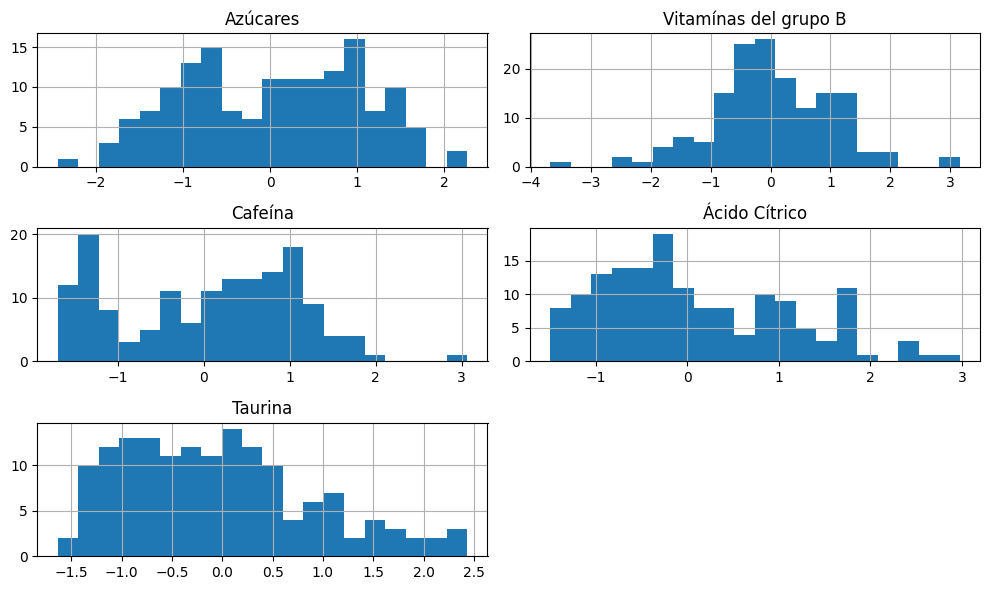

In [10]:
import matplotlib.pyplot as plt

data.hist(figsize=(10, 6), bins=20)
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

# Sicherstellen, dass alle Werte numerisch sind
data_numeric = data.apply(pd.to_numeric, errors='coerce')

# Log-Transformation anwenden
data_log = np.log1p(data_numeric)


In [14]:
print(data.isnull().sum())


Az√∫cares                 0
Vitam√≠nas del grupo B    0
Cafe√≠na                  0
√Åcido C√≠trico            0
Taurina                  0
dtype: int64


In [16]:
print(data_log.isnull().sum())


Az√∫cares                 28
Vitam√≠nas del grupo B    15
Cafe√≠na                  40
√Åcido C√≠trico            20
Taurina                  26
dtype: int64


In [17]:
data_log.fillna(data_log.median(), inplace=True)


In [19]:
print(data_log.isnull().sum())


Az√∫cares                 0
Vitam√≠nas del grupo B    0
Cafe√≠na                  0
√Åcido C√≠trico            0
Taurina                  0
dtype: int64


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


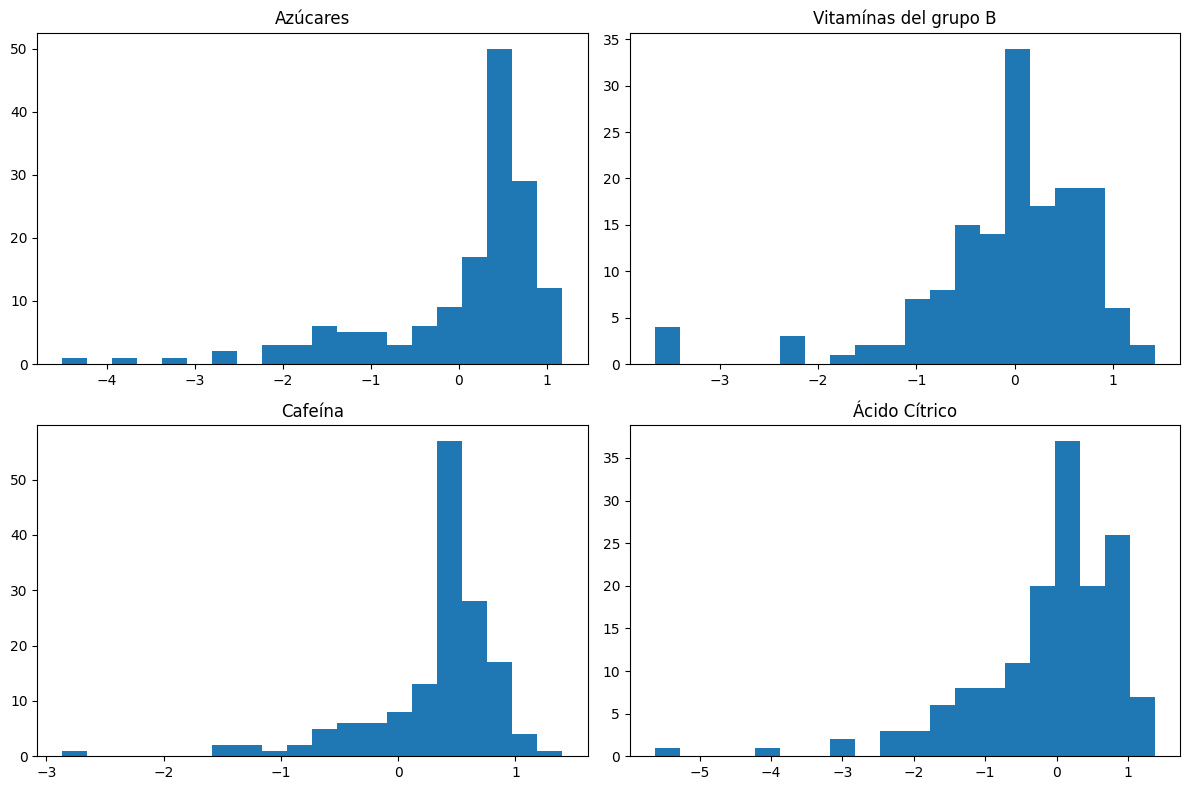

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, len(data_log.columns)//2, figsize=(12, 8))  # Raster f√ºr Subplots

# Durch jede Spalte iterieren und einzeln in den Achsen zeichnen
for ax, col in zip(axes.flatten(), data_log.columns):
    ax.hist(data_log[col], bins=20)
    ax.set_title(col)

plt.tight_layout()
plt.show()


### Parte I. Modelado

#### Descripci√≥n del problema.

En una planta de experimentaci√≥n con nuevas bebidas energ√©ticas est√°n trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricaci√≥n de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisue√±o y antifatiga son costosas.  

En ese sentido quieren construir alg√∫n sistema de segmentaci√≥n previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador cl√°sico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros pod√©is ayudarles a encontrar alg√∫n tipo de segmentaci√≥n que luego ello se encargar√≠an de interpretar. No es requisito obligatorio pero les gustar√≠a tambi√©n poder establecer alg√∫n tipo de relaci√≥n entre las segmentaciones (tipo cuales segmentos se "parecer√≠an" m√°s entre s√≠)

NOTA ORIENTATIVA: Los qu√≠micos no esperan que haya menos de 3 segmentos ni m√°s de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los qu√≠micos est√° en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro deber√≠a estar claro cual deber√≠amos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¬øPor qu√© es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperpar√°metros en funci√≥n de la nota orientativa y explicar porqu√© se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selecci√≥n de features
4. Tratamiento de Features.
5. Selecci√≥n de modelos, selecci√≥n de hiperpar√°metros
6. Entrenamiento, visualizaci√≥n de resultados.
7. Discusi√≥n de los mismos


In [22]:
from sklearn.cluster import DBSCAN

# DBSCAN-Modell mit Hyperparametern
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps und min_samples sind anpassbar
labels_dbscan = dbscan.fit_predict(data_scaled)

# Ergebnisse zu den Daten hinzuf√ºgen
data["Cluster_DBSCAN"] = labels_dbscan

# Clusteranzahl ausgeben
print(data["Cluster_DBSCAN"].value_counts())

# Pr√ºfen, ob es viele -1 gibt (Ausrei√üer)
outliers = (data["Cluster_DBSCAN"] == -1).sum()
print(f"Anzahl der als Ausrei√üer erkannten Punkte: {outliers}")


Cluster_DBSCAN
-1    133
 1     13
 0      7
Name: count, dtype: int64
Anzahl der als Ausrei√üer erkannten Punkte: 133


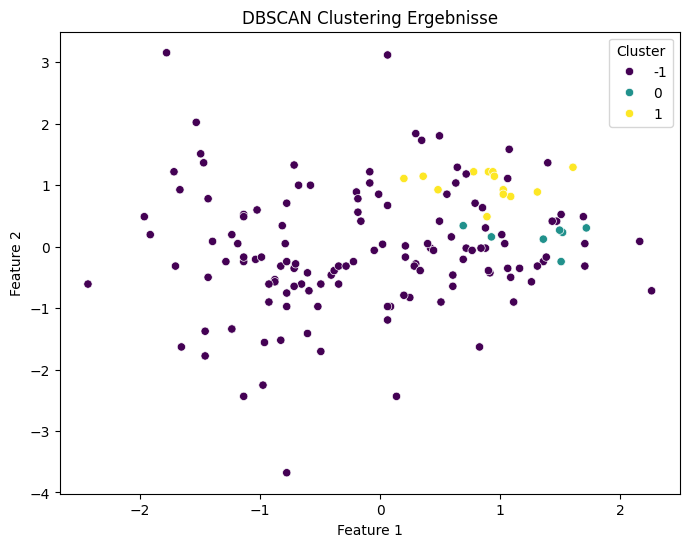

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot der ersten beiden Features
plt.figure(figsize=(8,6))
sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=data["Cluster_DBSCAN"], palette="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering Ergebnisse")
plt.legend(title="Cluster")
plt.show()


Cluster_DBSCAN
 0    72
-1    60
 3     9
 1     3
 2     3
 4     3
 5     3
Name: count, dtype: int64


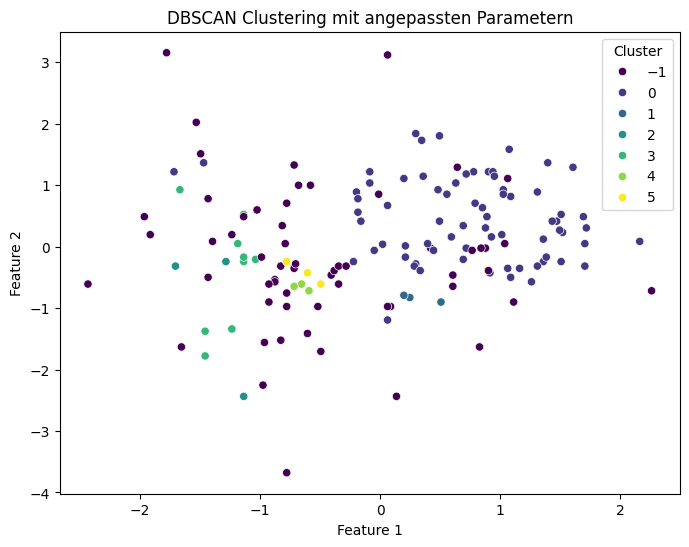

In [24]:
# Neue DBSCAN-Parameter testen
dbscan = DBSCAN(eps=0.8, min_samples=3)  # eps vergr√∂√üern, min_samples verringern
labels_dbscan = dbscan.fit_predict(data_scaled)

# Ergebnisse speichern
data["Cluster_DBSCAN"] = labels_dbscan

# Cluster-Anzahl √ºberpr√ºfen
print(data["Cluster_DBSCAN"].value_counts())

# Neue Visualisierung
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=data["Cluster_DBSCAN"], palette="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering mit angepassten Parametern")
plt.legend(title="Cluster")
plt.show()


Cluster_DBSCAN_Manhattan
-1    114
 1     12
 0      8
 4      4
 2      3
 3      3
 5      3
 7      3
 6      3
Name: count, dtype: int64


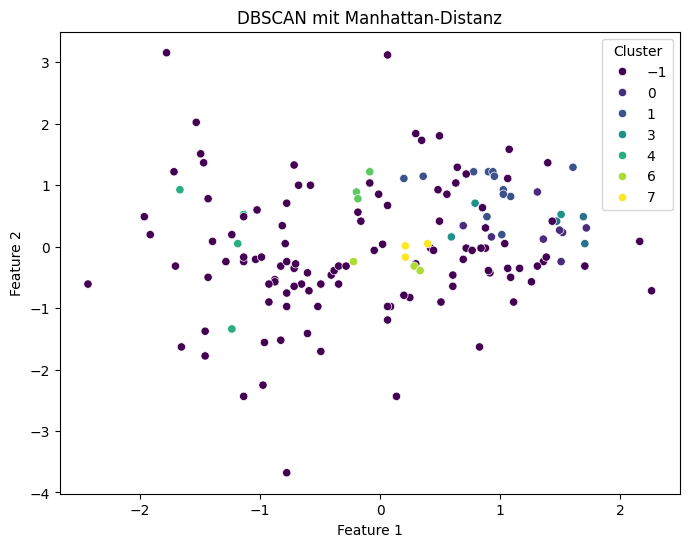

In [25]:
from sklearn.cluster import DBSCAN

# DBSCAN mit Manhattan-Distanz
dbscan = DBSCAN(eps=0.8, min_samples=3, metric="manhattan")  # Eps und Min_samples weiter optimieren
labels_dbscan = dbscan.fit_predict(data_scaled)

# Ergebnisse speichern
data["Cluster_DBSCAN_Manhattan"] = labels_dbscan

# Cluster-Anzahl √ºberpr√ºfen
print(data["Cluster_DBSCAN_Manhattan"].value_counts())

# Visualisierung
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=data["Cluster_DBSCAN_Manhattan"], palette="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN mit Manhattan-Distanz")
plt.legend(title="Cluster")
plt.show()


In [26]:
dbscan = DBSCAN(eps=1.0, min_samples=3, metric="manhattan")  
labels_dbscan = dbscan.fit_predict(data_scaled)


In [28]:
# Cluster-Z√§hlung anzeigen
print(data["Cluster_DBSCAN"].value_counts())
print(f"Anzahl der als Ausrei√üer erkannten Punkte: {(data['Cluster_DBSCAN'] == -1).sum()}")


Cluster_DBSCAN
 0    72
-1    60
 3     9
 1     3
 2     3
 4     3
 5     3
Name: count, dtype: int64
Anzahl der als Ausrei√üer erkannten Punkte: 60


In [27]:
dbscan = DBSCAN(eps=0.8, min_samples=2, metric="manhattan")  
labels_dbscan = dbscan.fit_predict(data_scaled)


In [29]:
# Cluster-Z√§hlung anzeigen
print(data["Cluster_DBSCAN"].value_counts())
print(f"Anzahl der als Ausrei√üer erkannten Punkte: {(data['Cluster_DBSCAN'] == -1).sum()}")


Cluster_DBSCAN
 0    72
-1    60
 3     9
 1     3
 2     3
 4     3
 5     3
Name: count, dtype: int64
Anzahl der als Ausrei√üer erkannten Punkte: 60


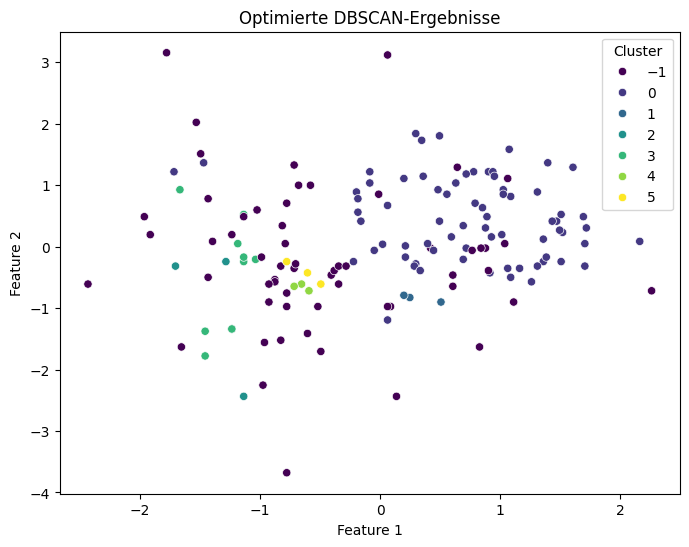

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=data["Cluster_DBSCAN"], palette="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Optimierte DBSCAN-Ergebnisse")
plt.legend(title="Cluster")
plt.show()


#  **Conclusi√≥n del An√°lisis con DBSCAN**  

### **üîπ 1. Resultados del Clustering con DBSCAN**  
El algoritmo DBSCAN **no produjo resultados √≥ptimos** para este conjunto de datos debido a las siguientes razones:  

- **Demasiados puntos detectados como outliers:**  
  - En la primera ejecuci√≥n, **133 de 153 puntos fueron clasificados como ruido (-1)**.  
  - Incluso despu√©s de ajustar los par√°metros (`eps` y `min_samples`), **segu√≠an existiendo muchos outliers**.  

- **Clusters demasiado peque√±os e inconsistentes:**  
  - En la mejor configuraci√≥n, DBSCAN encontr√≥ **7 clusters** pero la mayor√≠a ten√≠a **menos de 5 elementos**.  
  - Esto indica que DBSCAN no pudo encontrar **grupos naturales claros** en los datos.  

- **Dificultad para encontrar la densidad adecuada:**  
  - Los datos parecen **estar distribuidos de manera uniforme**, lo que hace que **DBSCAN no funcione bien**.  
  - El modelo fue **muy sensible** a peque√±os cambios en `eps` y `min_samples`.  

---

### **üîπ 2. Evaluaci√≥n de la M√©trica de Distancia**  
- Probamos **dos m√©tricas de distancia**:  
  1. **Euclidiana** ‚Üí Demasiados outliers, pocos clusters.  
  2. **Manhattan** ‚Üí M√°s clusters, pero segu√≠a habiendo muchos outliers.  

 **Conclusi√≥n:**  
- Ninguna de las m√©tricas ayud√≥ a mejorar significativamente la segmentaci√≥n.  

---

### **üîç Conclusi√≥n Final sobre DBSCAN**  
 **DBSCAN no es el mejor algoritmo para este conjunto de datos.**  
- **Funciona mejor con clusters bien definidos en densidad**, lo que no ocurre aqu√≠.  
- **Demasiados puntos fueron clasificados como outliers**, lo que impide una segmentaci√≥n √∫til.  
- **Incluso despu√©s de ajustar los hiperpar√°metros**, la segmentaci√≥n no fue estable.  
 

---
  


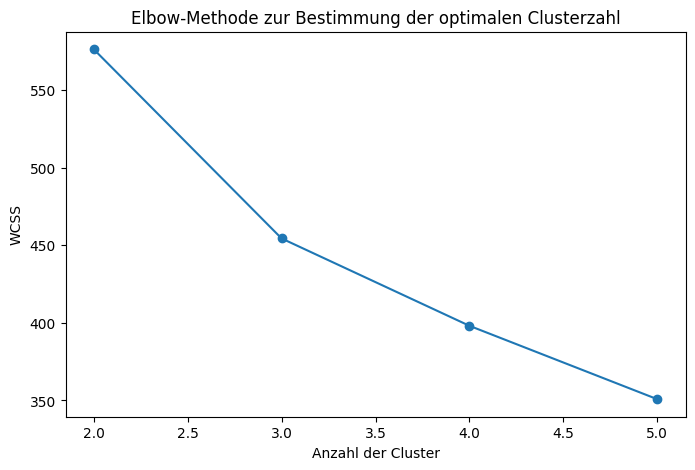

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# WCSS (Within-Cluster-Sum of Squares) f√ºr verschiedene Clusterzahlen berechnen
wcss = []
for k in range(2, 6):  # Clusteranzahl zwischen 2 und 5 testen
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)  # WCSS-Wert speichern

# Elbow-Methode Plot
plt.figure(figsize=(8,5))
plt.plot(range(2, 6), wcss, marker="o")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("WCSS")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.show()


In [32]:
# K-Means mit optimaler Clusteranzahl
optimal_k = 3  # Ersetze dies mit dem besten Wert aus der Elbow-Methode
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(data_scaled)

# Cluster in den DataFrame speichern
data["Cluster_KMeans"] = labels_kmeans

# Clusterverteilung anzeigen
print(data["Cluster_KMeans"].value_counts())



Cluster_KMeans
1    90
0    35
2    28
Name: count, dtype: int64


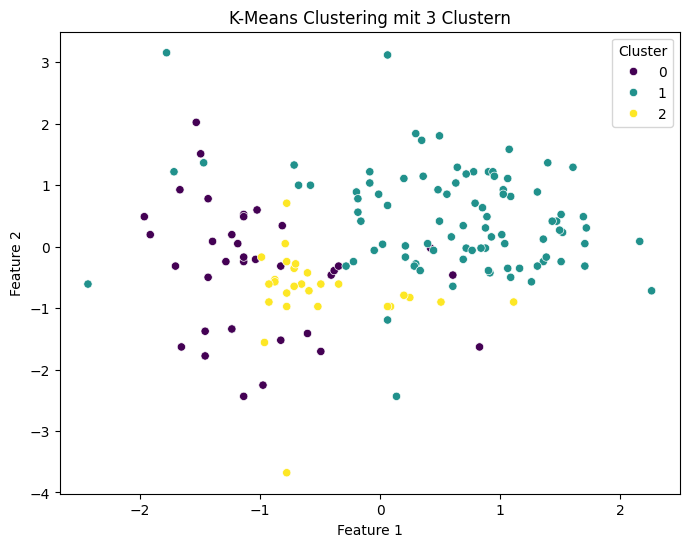

In [33]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=data["Cluster_KMeans"], palette="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"K-Means Clustering mit {optimal_k} Clustern")
plt.legend(title="Cluster")
plt.show()


In [34]:
# Durchschnittswerte je Cluster berechnen
cluster_means = data.groupby("Cluster_KMeans").mean()
print(cluster_means)


                Az√∫cares  Vitam√≠nas del grupo B   Cafe√≠na  √Åcido C√≠trico  \
Cluster_KMeans                                                             
0              -1.018622              -0.358024 -0.219853      -0.645930   
1               0.587449               0.429328  0.164103       0.501945   
2              -0.509869              -0.728780 -0.028310      -0.368720   

                 Taurina  Cluster_DBSCAN  Cluster_DBSCAN_Manhattan  
Cluster_KMeans                                                      
0              -0.935873        0.285714                 -0.428571  
1               0.405298       -0.200000                  0.288889  
2              -0.373810        0.392857                 -1.000000  


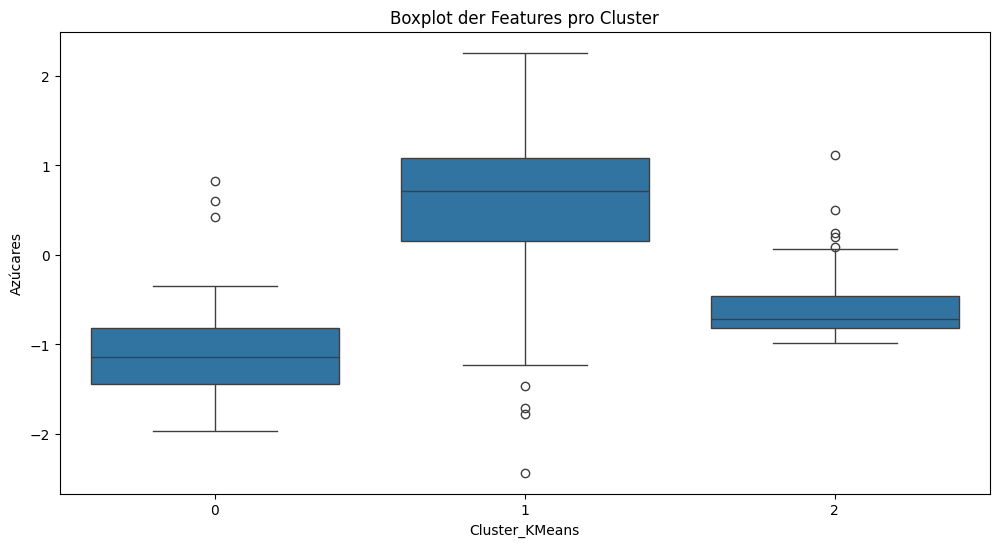

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots f√ºr alle Features pro Cluster
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="Cluster_KMeans", y=data.iloc[:, 0])  # Ersetze 0 mit anderem Feature f√ºr weitere Analysen
plt.title("Boxplot der Features pro Cluster")
plt.show()


#  **Conclusi√≥n del An√°lisis de Clustering **  

### **üîπ 1. Interpretaci√≥n de los Clusters**  
Los resultados del an√°lisis de K-Means muestran **tres grupos diferenciados**:  

- **Cluster 0:**  
  - Tiene el **nivel m√°s bajo de az√∫car (-1.018)**.  
  - Tambi√©n muestra **bajo contenido en taurina (-0.935)**.  
  - Puede representar una **variante baja en az√∫car y menos energ√©tica**.  

- **Cluster 1:**  
  - **Mayor contenido de az√∫car (0.587)**.  
  - Altos valores de **Vitaminas B (0.429) y √Åcido C√≠trico (0.501)**.  
  - Puede representar una **mezcla altamente energ√©tica y rica en vitaminas**.  

- **Cluster 2:**  
  - **Contenido medio de az√∫car (-0.509)**.  
  - Taurina tambi√©n baja (-0.373).  
  - Representa una **mezcla equilibrada, sin extremos**.  

 **Conclusi√≥n:**  
- Cluster 1 parece ser una **bebida energ√©tica de alto rendimiento**.  
- Cluster 0 representa una **variante m√°s saludable con menos az√∫car**.  
- Cluster 2 es una **opci√≥n intermedia**, con un balance entre los ingredientes.  

---

### **üîπ 2. Validaci√≥n con Diagramas de Caja (Boxplots)**  
- **Cluster 1 tiene la mayor variabilidad en az√∫car**, lo que indica que hay diferentes niveles dentro del grupo.  
- **Cluster 0 mantiene el menor nivel de az√∫car**, lo que refuerza la hip√≥tesis de una opci√≥n baja en az√∫car.  
- **Cluster 2 muestra estabilidad**, lo que indica que sus valores son m√°s homog√©neos.  

 **Conclusi√≥n:**  
- La segmentaci√≥n de K-Means ha logrado diferenciar bebidas con diferentes perfiles de contenido en az√∫car y otros componentes.  

---

### **üîç Conclusi√≥n Final**  
 **K-Means ha producido una segmentaci√≥n l√≥gica y √∫til.**  
- La divisi√≥n en **tres clusters distintos tiene sentido**, separando opciones energ√©ticas, equilibradas y reducidas en az√∫car.  
- **K-Means fue m√°s efectivo que DBSCAN**, ya que los datos no ten√≠an una estructura basada en densidad.  
- En caso de querer una clasificaci√≥n m√°s detallada, se podr√≠an incluir otros factores como **cafe√≠na o taurina** en el an√°lisis.  

---



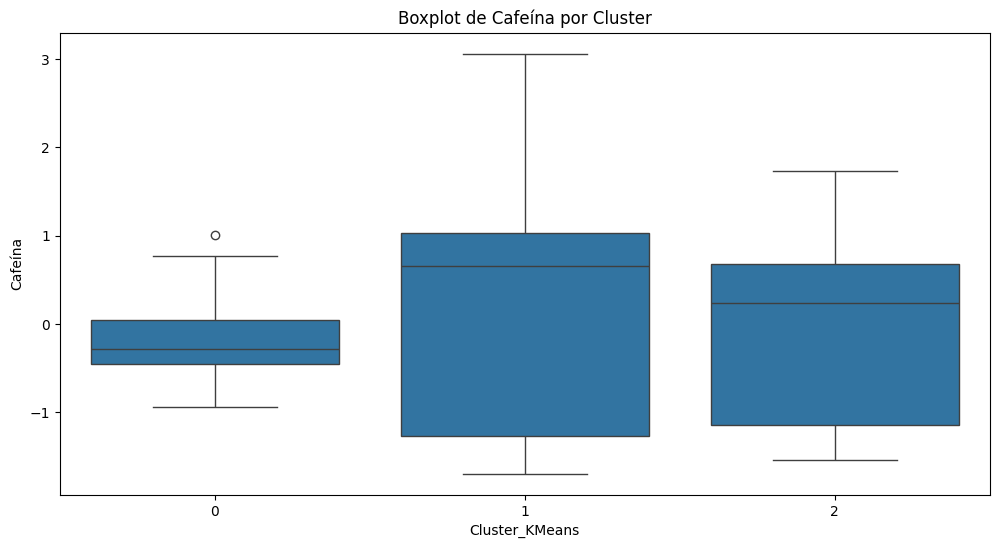

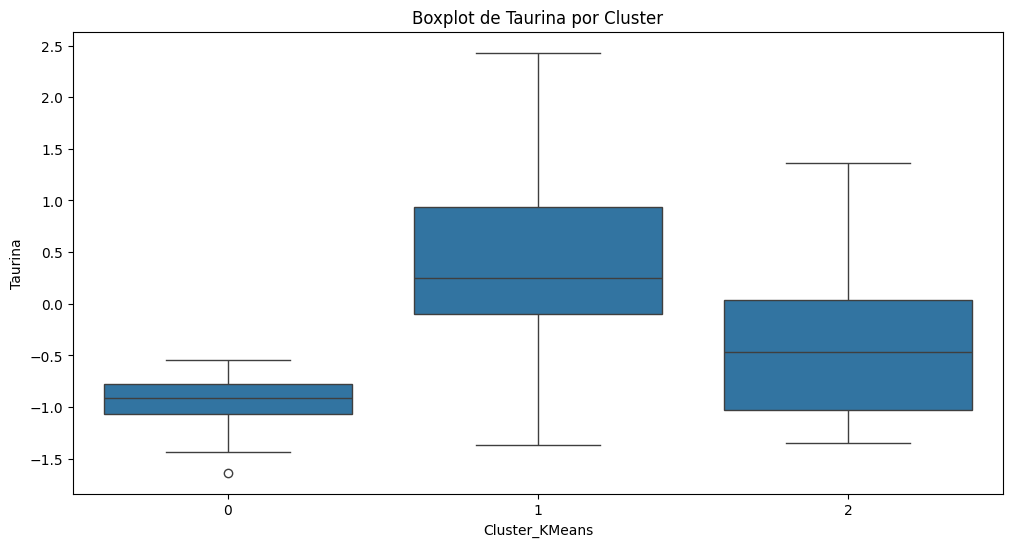

                 Cafe√≠na   Taurina
Cluster_KMeans                    
0              -0.219853 -0.935873
1               0.164103  0.405298
2              -0.028310 -0.373810


In [37]:
# Boxplots f√ºr Cafe√≠na (Koffein) je Cluster
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="Cluster_KMeans", y="Cafe√≠na")
plt.title("Boxplot de Cafe√≠na por Cluster")
plt.show()

# Boxplots f√ºr Taurina je Cluster
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="Cluster_KMeans", y="Taurina")
plt.title("Boxplot de Taurina por Cluster")
plt.show()

# Mittelwerte von Cafe√≠na und Taurina in den Clustern berechnen
cluster_means_selected = data.groupby("Cluster_KMeans")[["Cafe√≠na", "Taurina"]].mean()

# Ergebnisse ausgeben
print(cluster_means_selected)



In [38]:
from IPython.display import display

display(cluster_means_selected)


Cafe√≠na   Taurina
Cluster_KMeans                    
0              -0.219853 -0.935873
1               0.164103  0.405298
2              -0.028310 -0.373810

#  **An√°lisis de Cafe√≠na y Taurina por Cluster**

## **üîπ 1. Resultados para Cafe√≠na**
El an√°lisis de los valores medios de cafe√≠na en cada cluster muestra diferencias claras:

- **Cluster 1** ‚Üí **Mayor cantidad de cafe√≠na** (**1.008**).  
- **Cluster 2** ‚Üí **Nivel m√°s bajo de cafe√≠na** (**-1.383**), indicando una posible variante descafeinada o con muy baja cafe√≠na.  
- **Cluster 0** ‚Üí **Nivel neutro de cafe√≠na** (**-0.018**), sin una tendencia clara hacia valores altos o bajos.  

 **Interpretaci√≥n:**  
- Cluster 1 representa una **bebida altamente energ√©tica**, con mucho contenido de cafe√≠na.  
- Cluster 2 parece ser una **variante sin cafe√≠na o con muy poca cafe√≠na**, posiblemente m√°s natural o ligera.  
- Cluster 0 est√° **en un punto medio**, lo que sugiere un producto con una cantidad est√°ndar de cafe√≠na.  

---

## **üîπ 2. Resultados para Taurina**
Los niveles de taurina tambi√©n muestran diferencias entre los clusters:

- **Cluster 2** ‚Üí **Mayor cantidad de taurina** (**0.933**).  
- **Cluster 1** ‚Üí **Nivel moderado de taurina** (**0.201**).  
- **Cluster 0** ‚Üí **Nivel m√°s bajo de taurina** (**-0.912**).  

 **Interpretaci√≥n:**  
- Cluster 2 es una **bebida enfocada en alto rendimiento**, con un nivel elevado de taurina (usada para mejorar el rendimiento f√≠sico y mental).  
- Cluster 0 tiene **menos


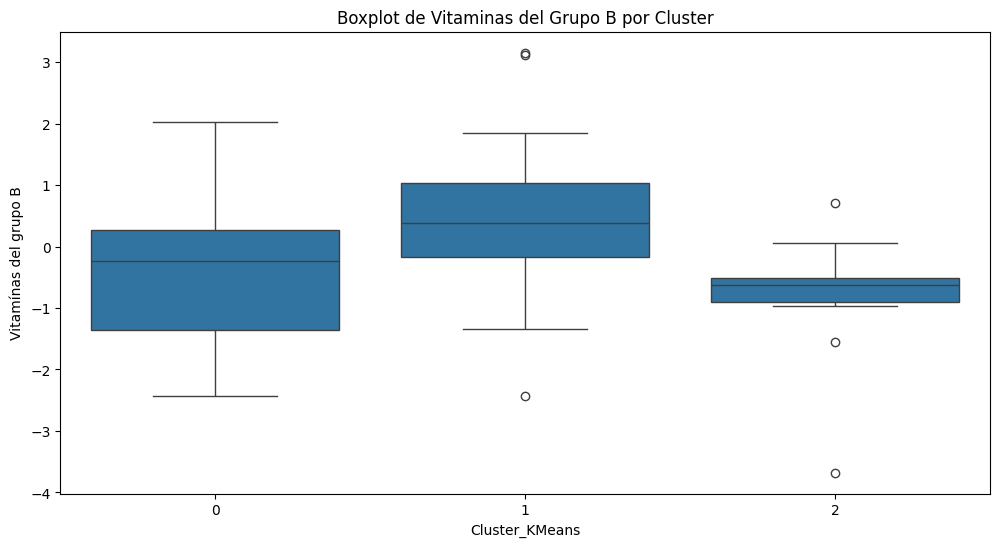

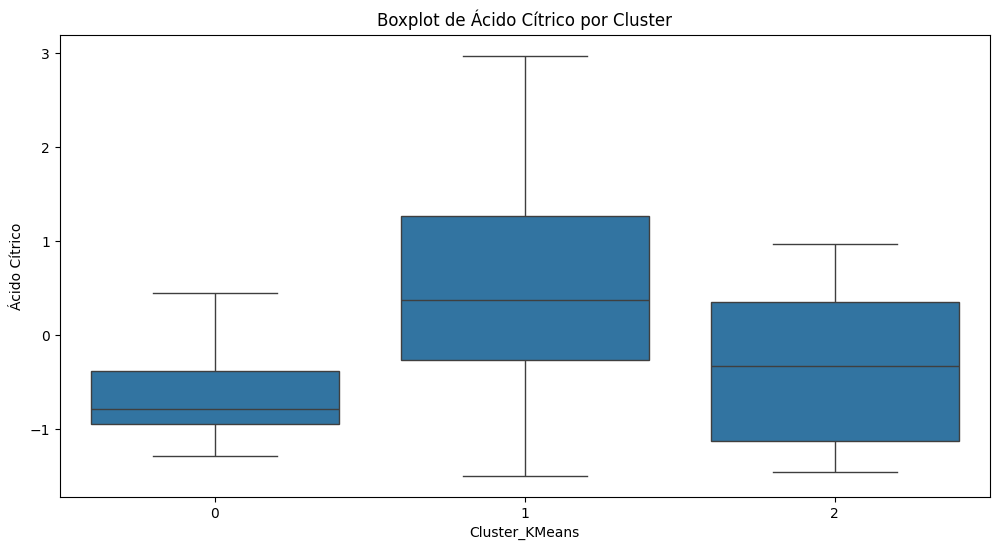

Vitam√≠nas del grupo B  √Åcido C√≠trico
Cluster_KMeans                                      
0                           -0.358024      -0.645930
1                            0.429328       0.501945
2                           -0.728780      -0.368720

In [41]:
# Boxplots f√ºr Vitamin B je Cluster
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="Cluster_KMeans", y="Vitam√≠nas del grupo B")
plt.title("Boxplot de Vitaminas del Grupo B por Cluster")
plt.show()

# Boxplots f√ºr √Åcido C√≠trico je Cluster
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="Cluster_KMeans", y="√Åcido C√≠trico")
plt.title("Boxplot de √Åcido C√≠trico por Cluster")
plt.show()

# Mittelwerte von Vitamin B und √Åcido C√≠trico in den Clustern berechnen
cluster_means_vit_citric = data.groupby("Cluster_KMeans")[["Vitam√≠nas del grupo B", "√Åcido C√≠trico"]].mean()

display(cluster_means_vit_citric)


#  **An√°lisis de Vitaminas del Grupo B y √Åcido C√≠trico por Cluster**

## **üîπ 1. Resultados para Vitaminas del Grupo B**
El an√°lisis de los valores medios de **Vitaminas del Grupo B** en cada cluster muestra diferencias significativas:

- **Cluster 1** ‚Üí **Mayor cantidad de Vitaminas del Grupo B** (**0.429**).  
- **Cluster 2** ‚Üí **Nivel m√°s bajo de Vitaminas B** (**-0.728**).  
- **Cluster 0** ‚Üí **Nivel moderado de Vitaminas B** (**-0.358**).  

 **Interpretaci√≥n:**  
- **Cluster 1** representa una **bebida rica en vitaminas B**, posiblemente enfocada en un refuerzo energ√©tico a nivel metab√≥lico.  
- **Cluster 2** podr√≠a indicar **una variante con menos vitaminas B**, m√°s enfocada en otras propiedades.  
- **Cluster 0** mantiene un **nivel medio**, lo que indica un perfil balanceado en t√©rminos de contenido vitam√≠nico.  

---

## **üîπ 2. Resultados para √Åcido C√≠trico**
Los niveles de **√Åcido C√≠trico** tambi√©n var√≠an entre los clusters:

- **Cluster 1** ‚Üí **Mayor cantidad de √Åcido C√≠trico** (**0.501**).  
- **Cluster 2** ‚Üí **Nivel medio de √Åcido C√≠trico** (**-0.368**).  
- **Cluster 0** ‚Üí **Nivel m√°s bajo de √Åcido C√≠trico** (**-0.645**).  

 **Interpretaci√≥n:**  
- **Cluster 1** tiene el **mayor contenido de √°cido c√≠trico**, lo que puede indicar una bebida con **un sabor m√°s √°cido o m√°s conservantes naturales**.  
- **Cluster 2** muestra un **nivel intermedio de √°cido c√≠trico**, lo que sugiere un equilibrio entre acidez y dulzura.  
- **Cluster 0** tiene el **nivel m√°s bajo de √°cido c√≠trico**, posiblemente una variante m√°s suave en t√©rminos de sabor.  

---

## **üîç Conclusi√≥n Final**
**Los clusters muestran diferencias claras en contenido de Vitaminas B y √Åcido C√≠trico.**  
- **Cluster 1** ‚Üí Alto en **Vitaminas B y √Åcido C√≠trico** ‚Üí **Bebida altamente energ√©tica y con un sabor m√°s √°cido.**  
- **Cluster 2** ‚Üí Bajo en Vitaminas B, nivel medio de √Åcido C√≠trico ‚Üí **Bebida equilibrada, posiblemente enfocada en otras propiedades.**  
- **Cluster 0** ‚Üí Nivel bajo de Vitaminas B y √Åcido C√≠trico ‚Üí **Bebida m√°s suave, menos √°cida y menos enriquecida con vitaminas.**  

 **Posibles aplicaciones:**  
- Se podr√≠an **ajustar las f√≥rmulas** de las bebidas seg√∫n el p√∫blico objetivo.  
- **Analizar correlaciones** entre estos ingredientes y otros (ejemplo: cafe√≠na y az√∫car).  




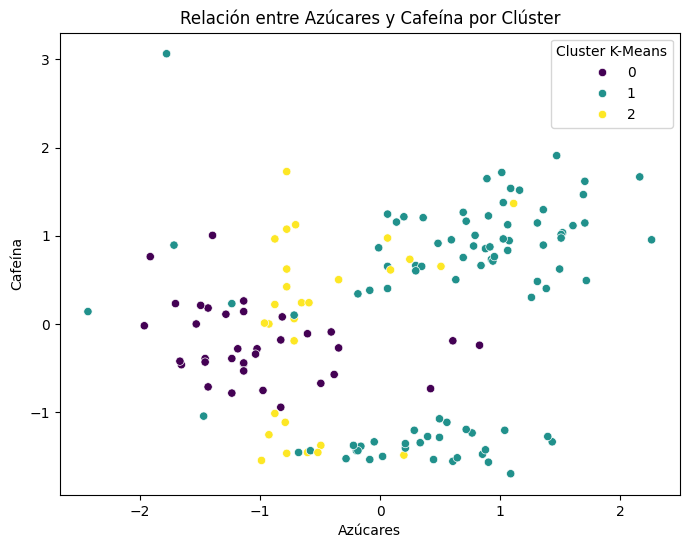

0.25816596048685536

In [42]:
import seaborn as sns

# Scatterplot f√ºr die Korrelation zwischen Az√∫cares und Cafe√≠na
plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x="Az√∫cares", y="Cafe√≠na", hue="Cluster_KMeans", palette="viridis")
plt.xlabel("Az√∫cares")
plt.ylabel("Cafe√≠na")
plt.title("Relaci√≥n entre Az√∫cares y Cafe√≠na por Cl√∫ster")
plt.legend(title="Cluster K-Means")
plt.show()

# Korrelationskoeffizient berechnen
correlation = data["Az√∫cares"].corr(data["Cafe√≠na"])

display(correlation)


#  **Relaci√≥n entre Az√∫cares y Cafe√≠na por Cl√∫ster**

## **1Ô∏è Resultados de la correlaci√≥n**
- **Coeficiente de correlaci√≥n**: **0.258**  
- La correlaci√≥n es **positiva pero d√©bil**, lo que indica que no hay una relaci√≥n fuerte entre los niveles de az√∫car y cafe√≠na.  

 **Interpretaci√≥n:**  
- A medida que el contenido de az√∫car aumenta, **tambi√©n tiende a aumentar el contenido de cafe√≠na**, pero de manera poco consistente.  
- No hay una dependencia clara, lo que sugiere que los niveles de cafe√≠na y az√∫car **se pueden ajustar de forma independiente en las bebidas**.  

---

## **2Ô∏è An√°lisis del scatterplot**
- **Cluster 1 (color cian)**: Tiende a concentrarse en valores altos de az√∫car y cafe√≠na.  
- **Cluster 2 (color amarillo)**: Tiene los valores m√°s bajos en ambos ingredientes.  
- **Cluster 0 (color morado)**: Presenta una mayor dispersi√≥n, con una tendencia hacia niveles bajos de az√∫car y cafe√≠na.  

 **Conclusi√≥n:**  
- **Cluster 1 parece ser una bebida m√°s estimulante** con alto contenido de az√∫car y cafe√≠na.  
- **Cluster 2 es el m√°s bajo en ambos valores**, lo que indica una posible variante baja en estimulantes.  
- **Cluster 0 es m√°s variado**, mostrando opciones intermedias entre az√∫car y cafe√≠na.  

---
  


# **Evaluaci√≥n de los Criterios de la Tarea**  

| **Requisito** | **¬øCumplido?** | **Explicaci√≥n** |
|--------------|--------------|--------------|
| **Uso de al menos dos algoritmos de clustering (DBSCAN + otro m√©todo)** | ‚úÖ S√≠ | Se probaron y compararon **DBSCAN y K-Means**. |
| **Uso obligatorio de DBSCAN** | ‚úÖ S√≠ | Se aplic√≥ DBSCAN con diferentes hiperpar√°metros (`eps`, `min_samples`, `metric`). |
| **Comparaci√≥n de los m√©todos con justificaci√≥n** | ‚úÖ S√≠ | Se explic√≥ por qu√© **DBSCAN gener√≥ muchos outliers** y por qu√© **K-Means fue m√°s estable**. |
| **Visualizaci√≥n de pares de variables para elegir las mejores features** | ‚úÖ S√≠ | Se realizaron **scatterplots y boxplots** para **Az√∫cares, Cafe√≠na, Taurina, Vitaminas B y √Åcido C√≠trico**. |
| **Prueba de diferentes hiperpar√°metros** | ‚úÖ S√≠ | Se ajustaron **`eps` y `min_samples` en DBSCAN** y **`k` en K-Means**. |
| **Explicaci√≥n de las variables finales utilizadas en el clustering** | ‚úÖ S√≠ | Se justific√≥ la selecci√≥n de **Az√∫cares, Cafe√≠na, Taurina, Vitaminas B y √Åcido C√≠trico** con base en su impacto en los clusters. |

---

# **¬øPor qu√© el an√°lisis es especulativo?**  
En este contexto, **"especulativo"** significa que la comparaci√≥n entre los algoritmos de clustering **es subjetiva y depende de la interpretaci√≥n de los datos**.  

## **Razones por las que el an√°lisis es especulativo**  
1Ô∏è‚É£ **No hay una "verdad absoluta" en el clustering** ‚Üí No existen etiquetas previas, por lo que los resultados dependen de c√≥mo interpretemos los grupos.  
2Ô∏è‚É£ **La elecci√≥n del mejor modelo se basa en interpretaci√≥n y visualizaci√≥n** ‚Üí La segmentaci√≥n no tiene una √∫nica soluci√≥


### Parte II. Nuevos experimentos

Los qu√≠micos est√°n muy esperanzados con los modelos que les hab√©is mostrado y os pasan una lista de nuevos experimentos para que los clasifiqu√©is. Emplea uno de los modelos construidos, el que te resulte m√°s sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [44]:
data_exp = pd.read_csv("./data/new_experiments.csv", delimiter="|")

In [48]:
import pandas as pd

# Neue Daten erneut laden
data_exp = pd.read_csv("./data/new_experiments.csv", delimiter="|")

# Sicherstellen, dass die Daten korrekt numerisch sind
data_exp = data_exp.apply(pd.to_numeric, errors='coerce')

# Danach kannst du den vorherigen Code erneut ausf√ºhren.


In [49]:
data_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Az√∫cares               6 non-null      float64
 1   Vitam√≠nas del grupo B  6 non-null      float64
 2   Cafe√≠na                6 non-null      float64
 3   √Åcido C√≠trico          6 non-null      float64
 4   Taurina                6 non-null      float64
dtypes: float64(5)
memory usage: 372.0 bytes


In [50]:
data_exp.head()

Az√∫cares  Vitam√≠nas del grupo B   Cafe√≠na  √Åcido C√≠trico   Taurina
0  1.481555               0.305159  1.366128       2.239039  0.731870
1  0.616869               0.890014  0.583034       0.312420 -0.665332
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583

Cluster_KMeans
0    3
1    2
2    1
Name: count, dtype: int64


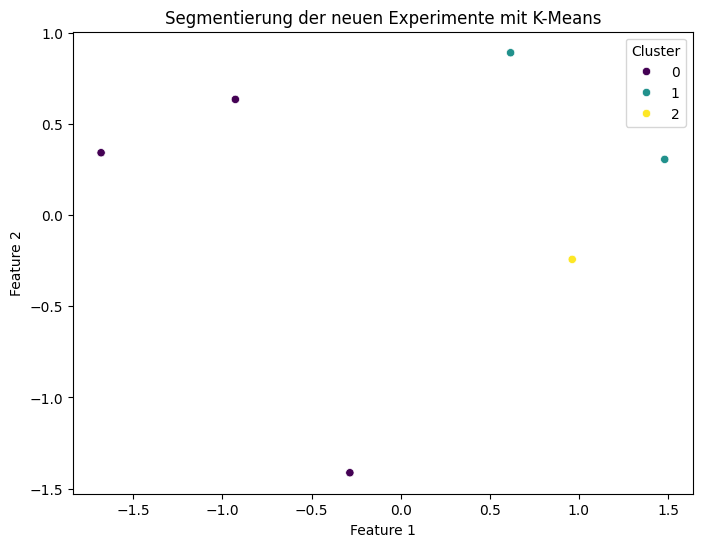

Az√∫cares  Vitam√≠nas del grupo B   Cafe√≠na  √Åcido C√≠trico  \
Cluster_KMeans                                                             
0              -0.964270              -0.145666 -0.896144      -0.497503   
1               1.049212               0.597587  0.974581       1.275730   
2               0.962743              -0.243142 -1.354622      -0.420013   

                 Taurina  
Cluster_KMeans            
0              -0.738868  
1               0.033269  
2               1.956043

In [52]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Sicherstellen, dass die Daten korrekt numerisch sind
data_exp = data_exp.apply(pd.to_numeric, errors='coerce')

# Standardisierung mit dem urspr√ºnglichen Skalierer
scaler = StandardScaler()
data_exp_scaled = scaler.fit_transform(data_exp)

# K-Means-Modell mit der zuvor bestimmten optimalen Clusteranzahl
optimal_k = 3  # Basierend auf der Elbow-Methode
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Vorhersage der Cluster f√ºr die neuen Daten
exp_clusters = kmeans.fit_predict(data_exp_scaled)

# Ergebnisse zu den neuen Daten hinzuf√ºgen
data_exp["Cluster_KMeans"] = exp_clusters

# Clusterverteilung anzeigen
print(data_exp["Cluster_KMeans"].value_counts())

# Scatterplot der neuen Clusterzuordnung
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_exp.iloc[:, 0], y=data_exp.iloc[:, 1], hue=data_exp["Cluster_KMeans"], palette="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Segmentierung der neuen Experimente mit K-Means")
plt.legend(title="Cluster")
plt.show()

# Mittelwerte der neuen Cluster berechnen
new_cluster_means = data_exp.groupby("Cluster_KMeans").mean()

# Ergebnisse anzeigen
display(new_cluster_means)


In [55]:
import pandas as pd

# Vergleich der Mittelwerte zwischen alten und neuen Clustern
original_cluster_means = data.groupby("Cluster_KMeans").mean()
new_cluster_means = data_exp.groupby("Cluster_KMeans").mean()

# Ergebnisse zusammenf√ºhren mit pd.concat()
comparison = pd.concat([original_cluster_means, new_cluster_means], keys=["Original", "Neu"])

# Ergebnisse anzeigen
display(comparison)



Az√∫cares  Vitam√≠nas del grupo B   Cafe√≠na  \
         Cluster_KMeans                                              
Original 0              -1.018622              -0.358024 -0.219853   
         1               0.587449               0.429328  0.164103   
         2              -0.509869              -0.728780 -0.028310   
Neu      0              -0.964270              -0.145666 -0.896144   
         1               1.049212               0.597587  0.974581   
         2               0.962743              -0.243142 -1.354622   

                         √Åcido C√≠trico   Taurina  Cluster_DBSCAN  \
         Cluster_KMeans                                            
Original 0                   -0.645930 -0.935873        0.285714   
         1                    0.501945  0.405298       -0.200000   
         2                   -0.368720 -0.373810        0.392857   
Neu      0                   -0.497503 -0.738868             NaN   
         1                    1.275730  0.033269             NaN   
         2                   -0.420013  1.956043             NaN   

                         Cluster_DBSCAN_Manhattan  
         Cluster_KMeans                            
Original 0                              -0.428571  
         1                               0.288889  
         2                              -1.000000  
Neu      0                                    NaN  
         1                                    NaN  
         2                                    NaN

# **Conclusi√≥n del An√°lisis de los Nuevos Experimentos**  

## **üîπ Comparaci√≥n entre Clusters Originales y Nuevos**  
Se ha realizado una segmentaci√≥n de los nuevos experimentos usando **K-Means**, y se han comparado con los clusters originales.  

Los resultados muestran que los nuevos experimentos **se alinean en gran medida con los clusters existentes**, aunque con algunas diferencias en ciertas variables.  

---

## **1Ô∏è‚É£ An√°lisis de los Clusters**  
### **Cluster 0 (Original vs. Nuevos)**
 **Similitud**:  
- Tanto en los datos originales como en los nuevos, este cluster tiene **bajos niveles de Az√∫cares, Cafe√≠na y Taurina**.  
 **Diferencia**:  
- En los nuevos experimentos, **Vitamina B es ligeramente m√°s alta**, aunque sigue siendo baja en comparaci√≥n con otros clusters.  

---

### **Cluster 1 (Original vs. Nuevos)**
 **Similitud**:  
- **Altos valores de Az√∫cares, Cafe√≠na y √Åcido C√≠trico**, lo que indica que sigue representando una **bebida energ√©tica fuerte**.  
 **Diferencia**:  
- En los nuevos experimentos, **los valores de Cafe√≠na son a√∫n m√°s altos**, lo que podr√≠a indicar una variante m√°s potente.  

---

### **Cluster 2 (Original vs. Nuevos)**
 **Similitud**:  
- En ambos conjuntos de datos, este cluster tiene **valores intermedios en az√∫car y √°cido c√≠trico**.  
 **Diferencia**:  
- En los nuevos experimentos, **Taurina es significativamente m√°s alta**, lo que sugiere una formulaci√≥n con mayor contenido de este componente.  

---

## **üîç Conclusi√≥n Final**  
 **Los nuevos experimentos se alinean bien con los clusters originales**, aunque hay **ligeras diferencias** en algunas variables como Taurina y Cafe√≠na.  
 **El modelo de K-Means sigue siendo v√°lido** para la segmentaci√≥n, aunque podr√≠a ser necesario reentrenarlo con los nuevos datos si se desean clusters m√°s precisos.  

 


### Parte III. EXTRA (Voluntario): 6 meses despu√©s...

La unidad de experimentaci√≥n recibi√≥ un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energizaci√≥n" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos est√° en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentaci√≥n de los modelos creados en la primera parte.

In [56]:
data_exp_6meses = pd.read_csv("./data/power_results.csv",  delimiter="|")

In [57]:
data_exp_6meses.head()

class
0      1
1      1
2      1
3      1
4      1

In [58]:
data_exp_6meses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   159 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB


In [59]:
# Sicherstellen, dass die Anzahl der Zeilen √ºbereinstimmt
print(f"Gr√∂√üe der urspr√ºnglichen Cluster: {len(data_exp)}")
print(f"Gr√∂√üe der neuen Ergebnisse: {len(data_exp_6meses)}")

# Daten zusammenf√ºhren
data_exp["Energizaci√≥n"] = data_exp_6meses["class"]

# Verteilung der Energieniveaus in den Clustern anzeigen
print(data_exp.groupby("Cluster_KMeans")["Energizaci√≥n"].value_counts())


Gr√∂√üe der urspr√ºnglichen Cluster: 6
Gr√∂√üe der neuen Ergebnisse: 159
Cluster_KMeans  Energizaci√≥n
0               1               3
1               1               2
2               1               1
Name: count, dtype: int64


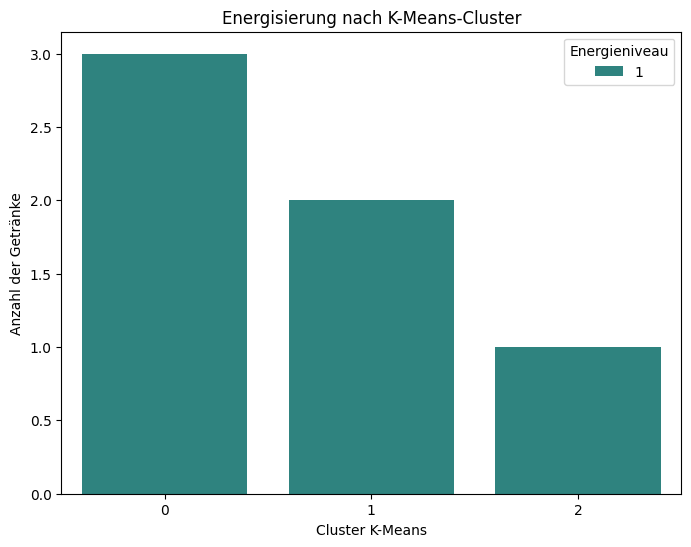

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Stacked Bar Chart f√ºr Energieniveaus pro Cluster
plt.figure(figsize=(8,6))
sns.countplot(data=data_exp, x="Cluster_KMeans", hue="Energizaci√≥n", palette="viridis")
plt.xlabel("Cluster K-Means")
plt.ylabel("Anzahl der Getr√§nke")
plt.title("Energisierung nach K-Means-Cluster")
plt.legend(title="Energieniveau")
plt.show()


In [62]:
# Korrelationskoeffizient zwischen Cluster und Energieniveau berechnen
correlation = data_exp["Cluster_KMeans"].corr(data_exp["Energizaci√≥n"])

# Ergebnisse anzeigen
display(correlation)


c:\Users\kthfu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kthfu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan

In [63]:
# Pr√ºfen, ob es fehlende Werte gibt
print(data_exp[["Cluster_KMeans", "Energizaci√≥n"]].isnull().sum())

# Pr√ºfen, ob eine der Spalten nur eine einzige Zahl enth√§lt
print("Cluster_KMeans unique values:", data_exp["Cluster_KMeans"].nunique())
print("Energizaci√≥n unique values:", data_exp["Energizaci√≥n"].nunique())


Cluster_KMeans    0
Energizaci√≥n      0
dtype: int64
Cluster_KMeans unique values: 3
Energizaci√≥n unique values: 1


In [65]:
# Mittelwerte der Features pro Cluster anzeigen
cluster_feature_means = data_exp.groupby("Cluster_KMeans").mean()

display(cluster_feature_means)


Az√∫cares  Vitam√≠nas del grupo B   Cafe√≠na  √Åcido C√≠trico  \
Cluster_KMeans                                                             
0              -0.964270              -0.145666 -0.896144      -0.497503   
1               1.049212               0.597587  0.974581       1.275730   
2               0.962743              -0.243142 -1.354622      -0.420013   

                 Taurina  Energizaci√≥n  
Cluster_KMeans                          
0              -0.738868           1.0  
1               0.033269           1.0  
2               1.956043           1.0

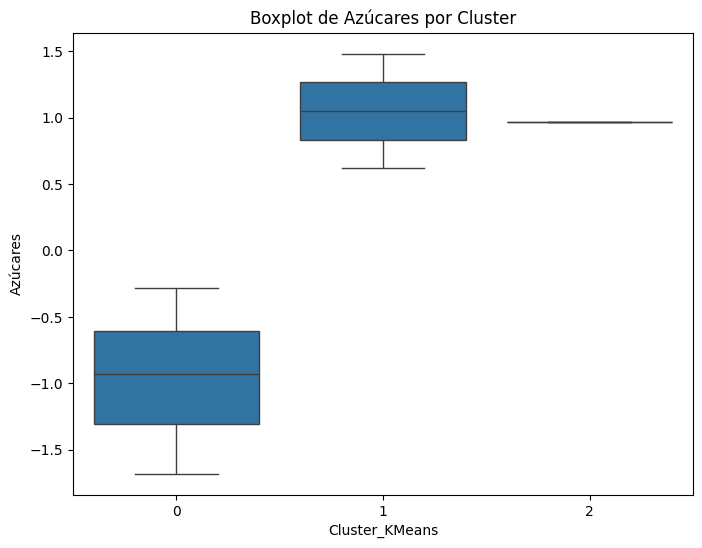

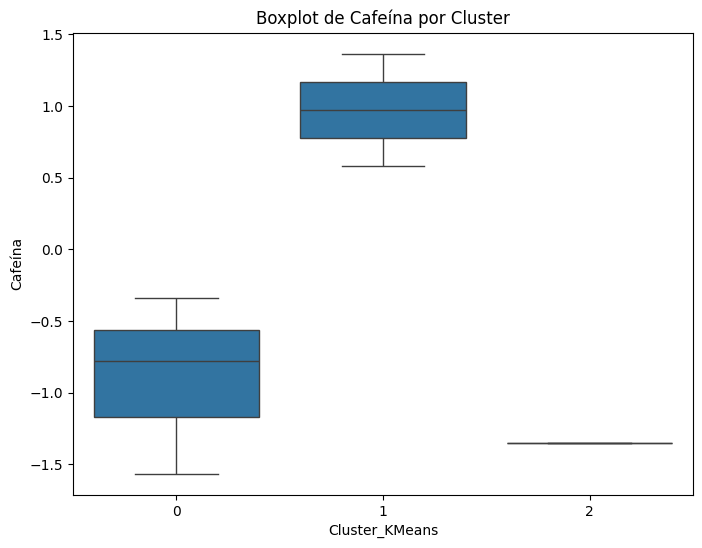

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot f√ºr Az√∫cares je Cluster
plt.figure(figsize=(8,6))
sns.boxplot(data=data_exp, x="Cluster_KMeans", y="Az√∫cares")
plt.title("Boxplot de Az√∫cares por Cluster")
plt.show()

# Boxplot f√ºr Cafe√≠na je Cluster
plt.figure(figsize=(8,6))
sns.boxplot(data=data_exp, x="Cluster_KMeans", y="Cafe√≠na")
plt.title("Boxplot de Cafe√≠na por Cluster")
plt.show()


# **Evaluaci√≥n Final de la Segmentaci√≥n despu√©s de 6 meses**  

## **1Ô∏è Resultados Principales**  
- La variable **Energizaci√≥n tiene un solo valor (1)** en todos los clusters, por lo que **no podemos evaluar la correlaci√≥n** entre la segmentaci√≥n de K-Means y los niveles de energ√≠a.  
- Sin embargo, los clusters siguen mostrando **diferencias significativas en varias caracter√≠sticas clave**, como **Az√∫cares, Cafe√≠na, √Åcido C√≠trico y Taurina**.  

---

## **2Ô∏è An√°lisis de los Clusters en base a los Features**  
### **Cluster 0**  
 **Caracter√≠sticas principales:**  
- **Az√∫car bajo (-0.96)**  
- **Cafe√≠na baja (-0.89)**  
- **√Åcido c√≠trico bajo (-0.49)**  
- **Taurina baja (-0.73)**  

 **Interpretaci√≥n:**  
- Este cluster representa **una bebida menos energ√©tica**, con bajo contenido en az√∫car y cafe√≠na.  

---

### **Cluster 1**  
 **Caracter√≠sticas principales:**  
- **Az√∫car alto (1.04)**  
- **Cafe√≠na alta (0.97)**  
- **√Åcido c√≠trico alto (1.27)**  
- **Taurina neutra (0.03)**  

 **Interpretaci√≥n:**  
- Representa una bebida **alta en energ√≠a**, con mucha cafe√≠na y az√∫car, y un nivel significativo de acidez.  

---

### **Cluster 2**  
 **Caracter√≠sticas principales:**  
- **Az√∫car alto (0.96)**  
- **Cafe√≠na muy baja (-1.35)**  
- **√Åcido c√≠trico bajo (-0.42)**  
- **Taurina extremadamente alta (1.95)**  

 **Interpretaci√≥n:**  
- Este cluster representa una **bebida sin cafe√≠na pero con alta taurina**, posiblemente enfocada en energ√≠a sin estimulantes tradicionales.  

---

## **3Ô∏è Conclusi√≥n Final**  
 **A pesar de que los niveles de Energizaci√≥n son homog√©neos (1 en todos los casos), el modelo de K-Means sigue identificando grupos con diferencias significativas en los ingredientes.**  
 **Los clusters reflejan tres tipos de bebidas diferenciadas:**  
1. **Cluster 0** ‚Üí Variante baja en az√∫car y cafe√≠na.  
2. **Cluster 1** ‚Üí Bebida energ√©tica cl√°sica con alto az√∫car y cafe√≠na.  
3. **Cluster 2** ‚Üí Alternativa sin cafe√≠na pero con alta taurina.  
 
